In [1]:
!pip install torchsummary
import os
import torch
import time
from lung_dataset import Lung_Dataset
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from matplotlib import pyplot as plt
from torchsummary import summary

model_path = "./model/"

In [3]:
ld_train1 = Lung_Dataset("train", "binary1")
ld_val1 = Lung_Dataset("val", "binary1")
ld_test1 = Lung_Dataset("test", "binary1")

ld_train2 = Lung_Dataset("train", "binary2")
ld_val2 = Lung_Dataset("val", "binary2")
ld_test2 = Lung_Dataset("test", "binary2")

print(ld_train1.describe())


Found augmented data: vanilla
Found augmented data: vanilla
Found augmented data: vanilla
Found augmented data: vanilla
Found augmented data: vanilla
Found augmented data: vanilla
This is the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5856 images, of size 150 by 150.
Images have been split in three groups: training, testing and validation sets.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/vanilla/train/normal: 1341 images.
 - train_infected_covid, in folder ./dataset/vanilla/train/infected/covid: 1345 images.
 - train_infected_noncovid, in folder ./dataset/vanilla/train/infected/non-covid: 2530 images.
 - val_normal, in folder ./dataset/vanilla/val/normal: 8 images.
 - val_infected_covid, in folder ./dataset/vanilla/val/infected/covid: 9 images.
 - val_infected_noncovid, in folder ./dataset/vanilla/val/infected/non

## Classifier#1 between normal and infected

In [4]:
class Model_binary_1(nn.Module):
    def __init__(self):
        super(Model_binary_1, self).__init__()
        
        # input img = 150x150
        # First block of Residual Block (3x3x16/2) + Pooling(2x2/2), output size = 19x19x16
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1)
        self.conv2 = nn.Conv2d(16, 16, 3, 2, 1)
        self.conv_skip1 = nn.Conv2d(1, 16, 1, 4)
        self.pool1 = nn.MaxPool2d(2, 2)
        # Second block of Residual Block (3x3x32/1) + Pooling(2x2/2), output size = 9x9x32
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv_skip2 = nn.Conv2d(16, 32, 1, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        # Third block of Residual Block (3x3x32/1) + Global Average Pooling, output size = 64
        self.conv5 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv6 = nn.Conv2d(64, 64, 3, 1, 1)
        self.conv_skip3 = nn.Conv2d(32, 64, 1, 1)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        # FC layer
        self.dropout1 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(32, 2)


    def forward(self, x):
        # Block 1
        residual1 = x
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        residual1 =  F.relu(self.conv_skip1(residual1))
        x += residual1
        x = self.pool1(x)
        
        # Block 2
        residual2 = x
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        residual2 =  F.relu(self.conv_skip2(residual2))
        x += residual2
        x = self.pool2(x)
        
        # Block 3
        residual3 = x
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        residual3 =  F.relu(self.conv_skip3(residual3))
        x += residual3
        x = self.gap(x)
        x = torch.flatten(x, 1)
        # FC
        x = self.dropout1(self.fc1(x)) 
        x = self.dropout2(self.fc2(x)) 

        output = F.log_softmax(x, dim=1)
        return output


In [5]:
class Model_binary_1(nn.Module):
    def __init__(self):
        super(Model_binary_1, self).__init__()
        
        # input img = 150x150
        # First block of Residual Block (3x3x16/2) + Pooling(2x2/2), output size = 19x19x16
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(num_features=16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(16, 16, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(num_features=16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv_skip1 = nn.Conv2d(1, 16, 1, 4)
        self.bn_skip1 = nn.BatchNorm2d(num_features=16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        # Second block of Residual Block (3x3x32/1) + Pooling(2x2/2), output size = 9x9x32
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4 = nn.Conv2d(32, 32, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv_skip2 = nn.Conv2d(16, 32, 1, 1)
        self.bn_skip2 = nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.pool2 = nn.MaxPool2d(2, 2)
        # Third block of Residual Block (3x3x32/1) + Global Average Pooling, output size = 64
        self.conv5 = nn.Conv2d(32, 64, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv6 = nn.Conv2d(64, 64, 3, 1, 1)
        self.bn6 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv_skip3 = nn.Conv2d(32, 64, 1, 1)
        self.bn_skip3 = nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        # FC layer
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(32, 2)


    def forward(self, x):
        # Block 1
        residual1 = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        residual1 =  F.relu(self.bn_skip1(self.conv_skip1(residual1)))
        x += residual1
        x = self.pool1(x)
        
        # Block 2
        residual2 = x
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        residual2 =  F.relu(self.bn_skip2(self.conv_skip2(residual2)))
        x += residual2
        x = self.pool2(x)
        
        # Block 3
        residual3 = x
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        residual3 =  F.relu(self.bn_skip3(self.conv_skip3(residual3)))
        x += residual3
        x = self.gap(x)
        x = torch.flatten(x, 1)
        # FC
        x = self.dropout1(self.fc1(x)) 
        x = self.dropout2(self.fc2(x)) 

        output = F.log_softmax(x, dim=1)
        return output


In [24]:
model = Model_binary_1()
print(summary(model, (1,150,150), device="cpu"))

# Define Parameter here:
model_type = "binary1"
batch_size = 128
n_epochs = 20
lr = 0.00005
steps = 0 
print_every = 40
device = "cuda"

train_loss_ls = []
val_loss_ls = []

time_stamp = str(time.time()).split(".")[0]
current_model_path = model_path + f"{model_type}-{time_stamp}-{n_epochs}e-{batch_size}b/"
os.mkdir(current_model_path)

train_loader1 = DataLoader(ld_train1, batch_size=batch_size, shuffle=True)
val_loader1 = DataLoader(ld_val1, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(ld_test1, batch_size=batch_size, shuffle=True)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr )
model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 75, 75]             160
       BatchNorm2d-2           [-1, 16, 75, 75]              32
            Conv2d-3           [-1, 16, 38, 38]           2,320
       BatchNorm2d-4           [-1, 16, 38, 38]              32
            Conv2d-5           [-1, 16, 38, 38]              32
       BatchNorm2d-6           [-1, 16, 38, 38]              32
         MaxPool2d-7           [-1, 16, 19, 19]               0
            Conv2d-8           [-1, 32, 19, 19]           4,640
       BatchNorm2d-9           [-1, 32, 19, 19]              64
           Conv2d-10           [-1, 32, 19, 19]           9,248
      BatchNorm2d-11           [-1, 32, 19, 19]              64
           Conv2d-12           [-1, 32, 19, 19]             544
      BatchNorm2d-13           [-1, 32, 19, 19]              64
        MaxPool2d-14             [-1, 3

Model_binary_1(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_skip1): Conv2d(1, 16, kernel_size=(1, 1), stride=(4, 4))
  (bn_skip1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_skip2): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (bn_skip

In [25]:
def validation(model, testloader, criterion, device):
    test_loss = 0
    accuracy = 0
    
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
                
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

running_loss = 0.0
for e in range(n_epochs):  # loop over the dataset multiple times
#     train_loss = 0.0
#     validation_loss = 0.0
#     total = 0

    # Training
    model.train()
#     train_loader1 = DataLoader(ld_train1, batch_size=batch_size, shuffle=True)
    for images, labels in train_loader1:
        images, labels = images.to(device), labels.to(device)
        steps += 1

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if steps % print_every == 0:
                # Eval mode for predictions
                model.eval()

                # Turn off gradients for validation
                with torch.no_grad():
                    test_loss, accuracy = validation(model, val_loader1, criterion, device)

                print("Epoch: {}/{} - ".format(e+1, n_epochs),
                      "Training Loss: {:.3f} - ".format(running_loss/print_every),
                      "Validation Loss: {:.3f} - ".format(test_loss/len(val_loader1)),
                      "Validation Accuracy: {:.3f}".format(accuracy/len(val_loader1)))
                
                train_loss_ls.append(running_loss/print_every)
                val_loss_ls.append(test_loss/len(val_loader1))
                running_loss = 0
                filepath = current_model_path + f"b{batch_size}-e{n_epochs}.pt"
                torch.save(model, filepath)

                # Make sure training is back on
                model.train()
        
#     # Validation
#     for _, data in enumerate(val_loader1, 0):
#         inputs, labels = data
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         validation_loss += loss.item()
#     train_loss_ls.append(train_loss/len(train_loader1))
#     val_loss_ls.append(validation_loss/len(val_loader1))
#     print(f"epoch {epoch}: {train_loss/len(train_loader1)} train loss, {validation_loss/len(val_loader1)} val loss")
    
#     if (epoch+1)%checkpoint_interval==0:
#         filepath = current_model_path + f"b{batch_size}-e{epoch}.pt"
#         torch.save(model.state_dict(), filepath)
        
print("Finished training")


def validation(model, testloader, criterion, device):
    test_loss = 0
    accuracy = 0
    
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
                
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

Epoch: 1/20 -  Training Loss: 0.587 -  Validation Loss: 0.636 -  Validation Accuracy: 0.680
Epoch: 2/20 -  Training Loss: 0.468 -  Validation Loss: 0.531 -  Validation Accuracy: 0.720
Epoch: 3/20 -  Training Loss: 0.406 -  Validation Loss: 0.504 -  Validation Accuracy: 0.760
Epoch: 4/20 -  Training Loss: 0.370 -  Validation Loss: 0.518 -  Validation Accuracy: 0.720
Epoch: 5/20 -  Training Loss: 0.344 -  Validation Loss: 0.535 -  Validation Accuracy: 0.720
Epoch: 6/20 -  Training Loss: 0.322 -  Validation Loss: 0.531 -  Validation Accuracy: 0.720
Epoch: 7/20 -  Training Loss: 0.303 -  Validation Loss: 0.544 -  Validation Accuracy: 0.720
Epoch: 8/20 -  Training Loss: 0.281 -  Validation Loss: 0.682 -  Validation Accuracy: 0.720
Epoch: 9/20 -  Training Loss: 0.259 -  Validation Loss: 0.514 -  Validation Accuracy: 0.720
Epoch: 10/20 -  Training Loss: 0.247 -  Validation Loss: 0.427 -  Validation Accuracy: 0.800
Epoch: 11/20 -  Training Loss: 0.231 -  Validation Loss: 0.476 -  Validation Ac

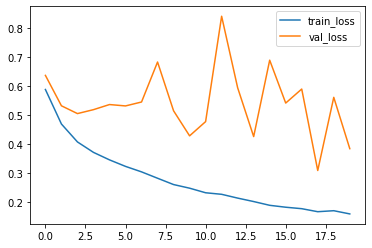

In [26]:
plt.plot(train_loss_ls, label = "train_loss")
plt.plot(val_loss_ls, label = "val_loss")
plt.legend()
plt.savefig(current_model_path+'train_val_loss.png')
plt.show()

In [28]:
correct = 0
total = 0

with torch.no_grad():
    model.eval()
    for images, labels in test_loader1:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 

In [32]:
accuracy = 0
with torch.no_grad():
    model.eval()
    for images, labels in test_loader1:
        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    print('Testing Accuracy: {:.3f}'.format(accuracy/len(test_loader1)))

Testing Accuracy: 0.808


## Classifier#2 between infected-covid and infected-noncovid

In [22]:
inputs, classes = next(iter(train_loader1))   
print(summary(model, tuple(inputs.shape[1:]), device="cuda"))
# tuple(inputs.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 75, 75]             160
       BatchNorm2d-2           [-1, 16, 75, 75]              32
            Conv2d-3           [-1, 16, 38, 38]           2,320
       BatchNorm2d-4           [-1, 16, 38, 38]              32
            Conv2d-5           [-1, 16, 38, 38]              32
       BatchNorm2d-6           [-1, 16, 38, 38]              32
         MaxPool2d-7           [-1, 16, 19, 19]               0
            Conv2d-8           [-1, 32, 19, 19]           4,640
       BatchNorm2d-9           [-1, 32, 19, 19]              64
           Conv2d-10           [-1, 32, 19, 19]           9,248
      BatchNorm2d-11           [-1, 32, 19, 19]              64
           Conv2d-12           [-1, 32, 19, 19]             544
      BatchNorm2d-13           [-1, 32, 19, 19]              64
        MaxPool2d-14             [-1, 3

In [14]:
model2 = Model_binary_1()
print(summary(model, (1,150,150), device="cuda"))

# Define Parameter here:
model_type = "binary2"
batch_size = 128
n_epochs = 30
lr = 0.00005
checkpoint_interval = 1
train_loss_ls = []
val_loss_ls = []

time_stamp = str(time.time()).split(".")[0]
current_model_path = model_path + f"{model_type}-{time_stamp}-{n_epochs}e-{batch_size}b/"
os.mkdir(current_model_path)

train_loader2 = DataLoader(ld_train2, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(ld_val2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(ld_test2, batch_size=batch_size, shuffle=True)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr )


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 75, 75]             160
       BatchNorm2d-2           [-1, 16, 75, 75]              32
            Conv2d-3           [-1, 16, 38, 38]           2,320
       BatchNorm2d-4           [-1, 16, 38, 38]              32
            Conv2d-5           [-1, 16, 38, 38]              32
       BatchNorm2d-6           [-1, 16, 38, 38]              32
         MaxPool2d-7           [-1, 16, 19, 19]               0
            Conv2d-8           [-1, 32, 19, 19]           4,640
       BatchNorm2d-9           [-1, 32, 19, 19]              64
           Conv2d-10           [-1, 32, 19, 19]           9,248
      BatchNorm2d-11           [-1, 32, 19, 19]              64
           Conv2d-12           [-1, 32, 19, 19]             544
      BatchNorm2d-13           [-1, 32, 19, 19]              64
        MaxPool2d-14             [-1, 3

In [15]:
for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    train_loss = 0.0
    validation_loss = 0.0
#     total = 0

    # Training
    for i, data in enumerate(train_loader2, 0):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_loss += loss.item()
#         print(f"current loss: {loss.item()}")
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
        
    # Validation
    for _, data in enumerate(val_loader2, 0):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        validation_loss += loss.item()
    train_loss_ls.append(train_loss/len(train_loader2))
    val_loss_ls.append(validation_loss/len(val_loader2))
    print(f"epoch {epoch}: {train_loss/len(train_loader2)} train loss, {validation_loss/len(val_loader2)} val loss")
    
    if (epoch+1)%checkpoint_interval==0:
        filepath = current_model_path + f"b{batch_size}-e{epoch}.pt"
        torch.save(model.state_dict(), filepath)
        
print("Finished training")


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

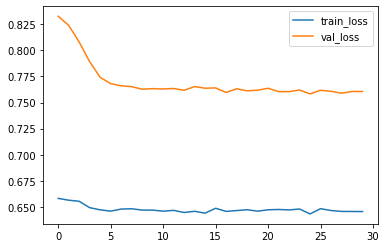

In [12]:
plt.plot(train_loss_ls, label = "train_loss")
plt.plot(val_loss_ls, label = "val_loss")
plt.legend()
plt.savefig(current_model_path+'train_val_loss.png')
plt.show()

In [14]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader2:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [1]:
import model_binary
!pip install torchsummary
import os
import torch
import time
from lung_dataset import Lung_Dataset
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from matplotlib import pyplot as plt
from torchsummary import summary

In [2]:
ld_train1 = Lung_Dataset("train", "binary1")
ld_val1 = Lung_Dataset("val", "binary1")
ld_test1 = Lung_Dataset("test", "binary1")

ld_train2 = Lung_Dataset("train", "binary2")
ld_val2 = Lung_Dataset("val", "binary2")
ld_test2 = Lung_Dataset("test", "binary2")

print(ld_train1.describe())

Found augmented data: vanilla
Found augmented data: vanilla
Found augmented data: vanilla
Found augmented data: vanilla
Found augmented data: vanilla
Found augmented data: vanilla
This is the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5856 images, of size 150 by 150.
Images have been split in three groups: training, testing and validation sets.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/vanilla/train/normal: 1341 images.
 - train_infected_covid, in folder ./dataset/vanilla/train/infected/covid: 1345 images.
 - train_infected_noncovid, in folder ./dataset/vanilla/train/infected/non-covid: 2530 images.
 - val_normal, in folder ./dataset/vanilla/val/normal: 8 images.
 - val_infected_covid, in folder ./dataset/vanilla/val/infected/covid: 9 images.
 - val_infected_noncovid, in folder ./dataset/vanilla/val/infected/non

In [3]:
batch_size = 128
n_epochs = 20
lr = 0.00001
saved_model_path =  "./model/"
device = "cuda"

classifier1 = model_binary.Model_binary_bn()
classifier2 = model_binary.Model_binary_bn()

classifier1.to(device)
classifier2.to(device)

train_loader1 = DataLoader(ld_train1, batch_size=batch_size, shuffle=True)
val_loader1 = DataLoader(ld_val1, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(ld_test1, batch_size=batch_size, shuffle=True)

train_loader2 = DataLoader(ld_train2, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(ld_val2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(ld_test2, batch_size=batch_size, shuffle=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 75, 75]             160
       BatchNorm2d-2           [-1, 16, 75, 75]              32
            Conv2d-3           [-1, 16, 38, 38]           2,320
       BatchNorm2d-4           [-1, 16, 38, 38]              32
            Conv2d-5           [-1, 16, 38, 38]              32
       BatchNorm2d-6           [-1, 16, 38, 38]              32
         MaxPool2d-7           [-1, 16, 19, 19]               0
            Conv2d-8           [-1, 32, 19, 19]           4,640
       BatchNorm2d-9           [-1, 32, 19, 19]              64
           Conv2d-10           [-1, 32, 19, 19]           9,248
      BatchNorm2d-11           [-1, 32, 19, 19]              64
           Conv2d-12           [-1, 32, 19, 19]             544
      BatchNorm2d-13           [-1, 32, 19, 19]              64
        MaxPool2d-14             [-1, 3

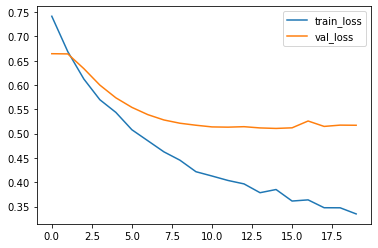

Model_binary_bn(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_skip1): Conv2d(1, 16, kernel_size=(1, 1), stride=(4, 4))
  (bn_skip1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_skip2): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (bn_ski

In [4]:
trained_classifier1 = model_binary.train(classifier1, batch_size, n_epochs, lr, train_loader1, val_loader1, saved_model_path)

In [6]:
model_binary.test_model(train_classifier1,test_loader1)

Testing Accuracy: 0.779


In [ ]:
trained_classifier2 = model_binary.train(classifier2, batch_size, n_epochs, lr, train_loader2, val_loader2, saved_model_path)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 75, 75]             160
       BatchNorm2d-2           [-1, 16, 75, 75]              32
            Conv2d-3           [-1, 16, 38, 38]           2,320
       BatchNorm2d-4           [-1, 16, 38, 38]              32
            Conv2d-5           [-1, 16, 38, 38]              32
       BatchNorm2d-6           [-1, 16, 38, 38]              32
         MaxPool2d-7           [-1, 16, 19, 19]               0
            Conv2d-8           [-1, 32, 19, 19]           4,640
       BatchNorm2d-9           [-1, 32, 19, 19]              64
           Conv2d-10           [-1, 32, 19, 19]           9,248
      BatchNorm2d-11           [-1, 32, 19, 19]              64
           Conv2d-12           [-1, 32, 19, 19]             544
      BatchNorm2d-13           [-1, 32, 19, 19]              64
        MaxPool2d-14             [-1, 3